In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
import json

In [2]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [3]:
with open('config.json') as f:
    config = json.load(f)

data_path = config["data_path"]

ts = pd.read_csv(data_path)

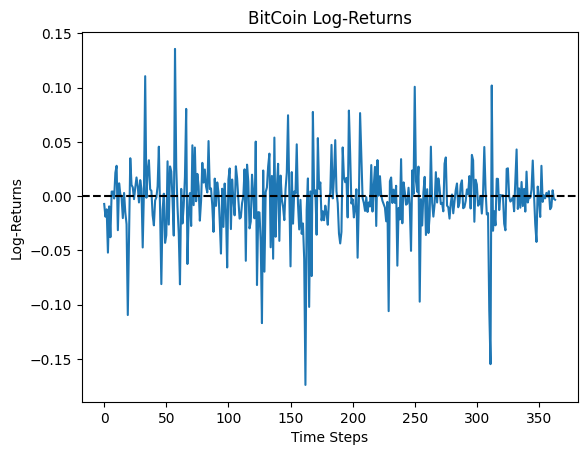

In [4]:
ts = ts["Close"].values
ts_log = np.log(ts)
returns = np.diff(ts_log)

plt.plot(returns)
plt.axhline(y=0, c="black", linestyle="--")
plt.title("BitCoin Log-Returns")
plt.xlabel('Time Steps')
plt.ylabel('Log-Returns')
plt.show()

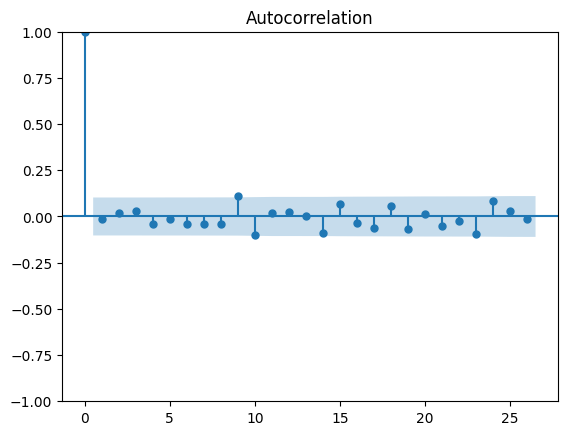

In [5]:
plot_acf(returns)
plt.show()

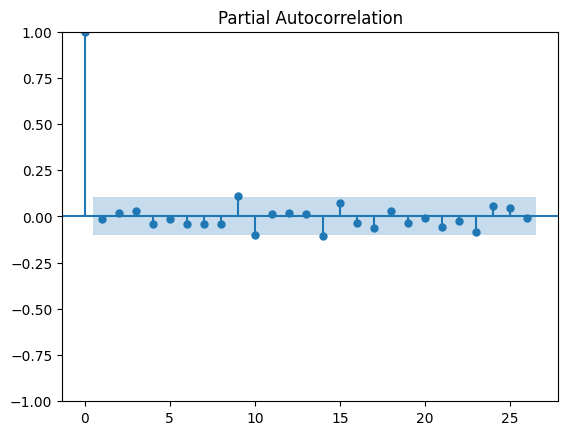

In [6]:
plot_pacf(returns)
plt.show()

In [7]:
unit_test = adfuller(returns)

#Print results
print('ADF Statistic: %f' % unit_test[0])
print('p-value: %f' % unit_test[1])
print('Critical Values:', unit_test[4])

if unit_test[1] <= 0.05:
    print(f'Reject the null hypothesis. The time-series is stationary.')
else: 
    print(f"Fail to reject the null hypothesis. The time-series is non-stationary")

ADF Statistic: -19.230854
p-value: 0.000000
Critical Values: {'1%': np.float64(-3.448493650810824), '5%': np.float64(-2.8695352280356556), '10%': np.float64(-2.5710293341377715)}
Reject the null hypothesis. The time-series is stationary.


In [22]:
# train-test split for time series
train_size = int(len(returns) * 0.70)
train, rest = returns[:train_size], returns[train_size:]
validation_size = int(len(rest) * 0.50)
validation, test = rest[:validation_size], rest[validation_size:]

In [23]:
lowest_aic = float('inf')
best_p_aic = None
best_q_aic = None

lowest_bic = float('inf')
best_p_bic = None
best_q_bic = None

for p in range(1,6):
    for q in range(1,6):
        #create model
        model=ARIMA(train, order=(p,0,q))
        results = model.fit()

        #AIC and BIC of model
        aic = results.aic
        bic = results.bic
        print(f"AR({p}), MA({q}), AIC: {aic}, BIC: {bic}")

        #Update the best order based on the lowest AIC
        if aic < lowest_aic:
            lowest_aic = aic
            best_p_aic = p
            best_q_aic = q
        
        #Update the best order based on the lowest BIC
        if bic < lowest_bic:
            lowest_bic = bic
            best_p_bic = p
            best_q_bic = q

print(f"\nBest ARMA order based on AIC: ({best_p_aic},0,{best_q_aic}) \nBest ARMA order based on BIC: ({best_p_bic},0,{best_q_bic})")

AR(1), MA(1), AIC: -964.6401229613102, BIC: -950.4907858932361
AR(1), MA(2), AIC: -963.5034814993425, BIC: -945.8168101642498


e:\Projects\Github\Predicting-Bitcoin-Returns-with-Long-Short-Term-Memory-LSTM-Neural-Networks\lstm-senior-project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
e:\Projects\Github\Predicting-Bitcoin-Returns-with-Long-Short-Term-Memory-LSTM-Neural-Networks\lstm-senior-project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR(1), MA(3), AIC: -961.6967775340734, BIC: -940.4727719319621
AR(1), MA(4), AIC: -959.6993169205925, BIC: -934.9379770514628
AR(1), MA(5), AIC: -957.8142694977681, BIC: -929.5155953616198
AR(2), MA(1), AIC: -962.6639309253856, BIC: -944.9772595902929
AR(2), MA(2), AIC: -963.943804097436, BIC: -942.7197984953248
AR(2), MA(3), AIC: -959.6945558629257, BIC: -934.9332159937959
AR(2), MA(4), AIC: -958.5683899036666, BIC: -930.2697157675183
AR(2), MA(5), AIC: -955.7028118734852, BIC: -923.8668034703184
AR(3), MA(1), AIC: -961.6303557726685, BIC: -940.4063501705573
AR(3), MA(2), AIC: -959.6629414117735, BIC: -934.9016015426438
AR(3), MA(3), AIC: -961.6519832742491, BIC: -933.3533091381008
AR(3), MA(4), AIC: -955.6689592448254, BIC: -923.8329508416585
AR(3), MA(5), AIC: -958.493828092188, BIC: -923.1204854220026
AR(4), MA(1), AIC: -959.667552901991, BIC: -934.9062130328613
AR(4), MA(2), AIC: -957.6712318149343, BIC: -929.372557678786
AR(4), MA(3), AIC: -958.1725094965577, BIC: -926.3365010933

In [10]:
model = ARIMA(train, order=(3,0,1))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  255
Model:                 ARIMA(3, 0, 1)   Log Likelihood                 487.514
Date:                Thu, 05 Dec 2024   AIC                           -963.027
Time:                        18:02:19   BIC                           -941.780
Sample:                             0   HQIC                          -954.481
                                - 255                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.002     -1.575      0.115      -0.009       0.001
ar.L1         -0.9433      0.096     -9.851      0.000      -1.131      -0.756
ar.L2          0.0367      0.094      0.388      0.6

In [11]:
fitted = results.fittedvalues

In [12]:
mse = mean_squared_error(train, fitted)
rmse = sqrt(mse)
print(f"Train RMSE: {rmse}")

Train RMSE: 0.035758661799796546


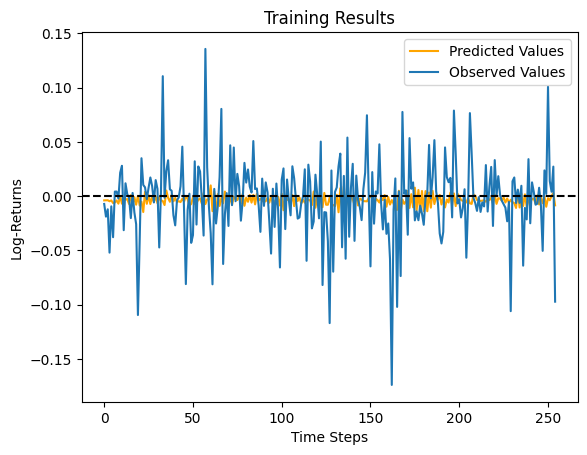

In [13]:
plt.plot(fitted, c='orange', label="Predicted Values")
plt.plot(train, label='Observed Values')
plt.axhline(y=0, c="black", linestyle="--")
plt.title("Training Results")
plt.xlabel('Time Steps')
plt.ylabel('Log-Returns')
plt.legend()
plt.show()

### Residual Diagnostics

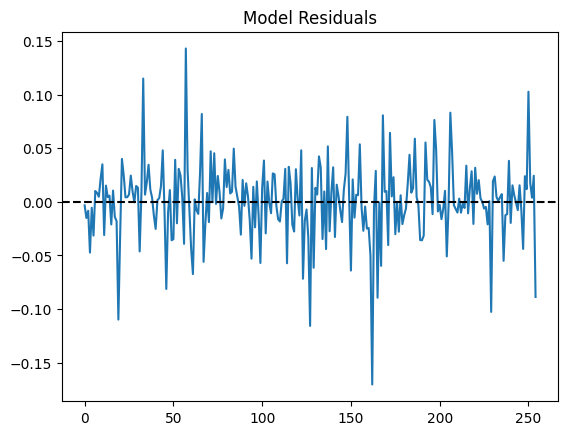

In [14]:
residuals = results.resid
plt.plot(residuals)
plt.axhline(y=0, c="black", linestyle="--")
plt.title("Model Residuals")
plt.show()

In [15]:
lagrange_t_stat, p_value, _, _ = acorr_breusch_godfrey(results, nlags=12)
print(f"Results from Breusch-Godfrey Test\nTest-Statistic: {lagrange_t_stat}\nP-Value: {p_value}")

if p_value <= 0.05:
    print(f"Reject the null hypothesis. Presence of serial correlation in the residuals is likely.")
else: 
    print(f"Fail to reject the null hypothesis. Evidence does not suggest serial correlation.")


Results from Breusch-Godfrey Test
Test-Statistic: 10.151472747755134
P-Value: 0.6026739139185489
Fail to reject the null hypothesis. Evidence does not suggest serial correlation.


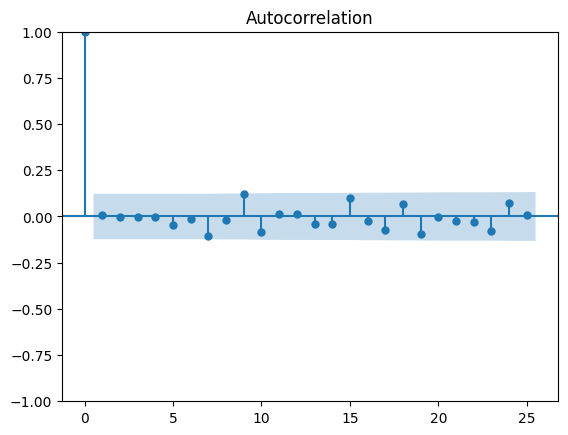

In [16]:
plot_acf(residuals)
plt.show()

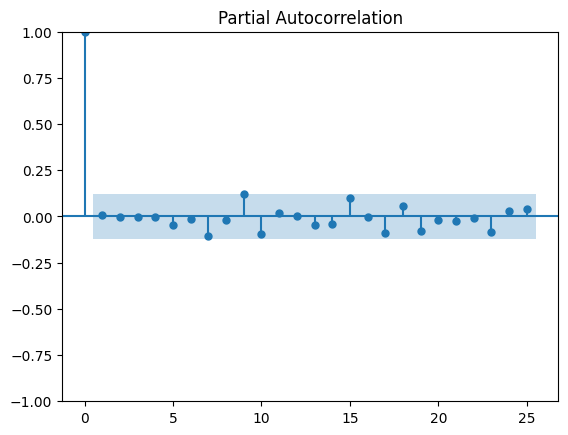

In [17]:
plot_pacf(residuals)
plt.show()

## Model Testing


In [18]:
def rolling_forecast():

    history = list(train)
    predictions = []

    for i in range(len(test+1)):
        model = ARIMA(history, order=(3,0,1))
        results = model.fit()
        
        #One-step-ahead forecast
        yhat = results.forecast()
        yhat = yhat[0]

        #Append history and predictions
        obs = test[i] #most recent observation
        history.append(obs)
        predictions.append(yhat)
        
        #Print predictions and observations at each step
        print(f'Step {i+1}: Observed: {obs}, Predicted: {yhat}')

    return predictions
            
yhat_test = rolling_forecast()

Step 1: Observed: -0.0027439687990540307, Predicted: 0.0030682377486740443
Step 2: Observed: -0.027034585929099464, Predicted: -0.010624103721913414
Step 3: Observed: 0.0036162278252707125, Predicted: -0.006264594221059169
Step 4: Observed: 0.01779449284384782, Predicted: -0.004852945177730453
Step 5: Observed: -0.03581280592216096, Predicted: -0.003929139827767367
Step 6: Observed: 0.006396912182601966, Predicted: -0.0016121793803511582
Step 7: Observed: -0.03400047787130056, Predicted: -0.004654717681553337
Step 8: Observed: -0.01834481341658112, Predicted: -0.003501088761113604
Step 9: Observed: 0.045641677518439394, Predicted: -0.004834114096323402
Step 10: Observed: -0.005988576329485795, Predicted: -0.006072315283024392
Step 11: Observed: -0.018864440546158434, Predicted: -0.0012931023431560092
Step 12: Observed: -0.007149857903650414, Predicted: -0.0016297955579808309
Step 13: Observed: 0.022121968217957644, Predicted: -0.004284754182923629
Step 14: Observed: -0.0058500341686418

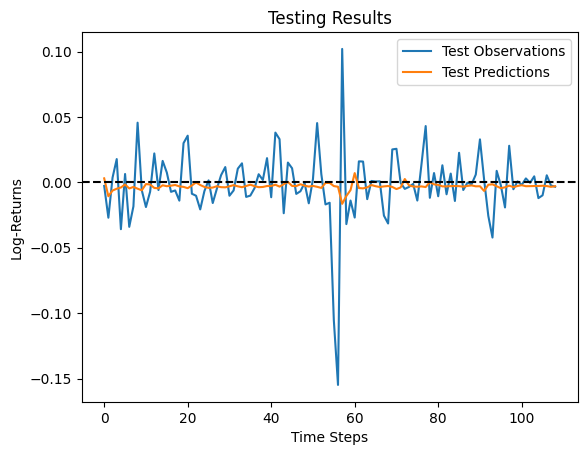

In [19]:
plt.plot(test, label='Test Observations')
plt.plot(yhat_test, label='Test Predictions')
plt.axhline(y=0, c="black", linestyle="--")
plt.title("Testing Results")
plt.xlabel('Time Steps')
plt.ylabel('Log-Returns')
plt.legend()
plt.show()

In [21]:
test_mse = mean_squared_error(test, yhat_test)
test_rmse = sqrt(test_mse)
print(f"Train RMSE: {test_rmse}")

Train RMSE: 0.0274461948997588


## Solving the underfitting issue

In [ ]:
class model_selection:
    def __init__(self, training_set, validation_set, testing_set):
        #
        self.training_set = training_set
        self.validation_set = validation_set
        self.testing_set = testing_set

    def training(self):
        '''
        The purpose of this function is to select the appropriate model based on model performance on the training set. 
        
        Input: self
        Output: optimal ARMA order based on AIC and BIC, respectively
        '''
        
        train = self.training_set

        lowest_aic = float('inf')
        best_p_aic = None
        best_q_aic = None

        lowest_bic = float('inf')
        best_p_bic = None
        best_q_bic = None

        for p in range(1,6):
            for q in range(1,6):
                #create model
                model = ARIMA(train, order=(p,0,q))
                results = model.fit()

                #AIC and BIC of model
                aic = results.aic
                bic = results.bic
                print(f"AR({p}), MA({q}), AIC: {aic}, BIC: {bic}")

                #Update the best order based on the lowest AIC
                if aic < lowest_aic:
                    lowest_aic = aic
                    best_p_aic = p
                    best_q_aic = q
                
                #Update the best order based on the lowest BIC
                if bic < lowest_bic:
                    lowest_bic = bic
                    best_p_bic = p
                    best_q_bic = q

        return best_p_aic, best_q_aic, best_p_bic, best_q_bic
    
    def valdiation(self):
        '''
        Selects the most optimal model parameters based on RMSE on the validation set. 

        Input: self
        Output: optimal p, optimal w, rmse, predictions
        '''
        
        validation_set = self.validation_set

        #These are the values to be returned by this function
        lowest_rmse = float('inf')
        best_p = None
        best_q = None

        history = list(self.validation_set)
        predictions = []

        #Run through each possible p and q in our selected range
        for p in range(1,11):
            for q in range(1,11):
                #Run through each valdiation set observation
                for i in range(len(validation_set+1)):
                    model = ARIMA(history, order=(3,0,1))
                    results = model.fit()
                    
                    #One-step-ahead forecast
                    yhat = results.forecast()
                    yhat = yhat[0]

                    #Append history and predictions
                    obs = validation_set[i] #most recent observation
                    history.append(obs)
                    predictions.append(yhat)
                    
                    #Print predictions and observations at each step
                    print(f'Step {i+1}: Observed: {obs}, Predicted: {yhat}')

        return best_p, best_q, lowest_rmse, predictions



